In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
%matplotlib inline

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

<H2 align="center"> Pre-Processing </H2>

In [3]:
data = pd.read_csv('../data/model_data/spatial_df/Lassa_spatialdataset_201219separateyears_labconfirmed.csv')
data.replace('',np.nan,regex = True)
data.dropna(inplace=True)

# Separate data so that we train the model on 2012-2017 data
# and test it's predictive ability against 2018-2019 data
df18 = data[(data['Year'] == 2018)].copy()
df19 = data[(data['Year'] == 2019)].copy()

In [4]:
# Creating LGA names set and then assigning them their indices as values
lga_names = set(data['LGA'])
lga_replace_dict = {value: i for i, value in enumerate(lga_names)}

# Creating Year names set and then assigning them their indices as values
year_names = set(data['Year'])
year_replace_dict = {value: i for i, value in enumerate(year_names)}

# Creating Admin names set and then assigning them their indices as values
administration_names = set(data['admin1Name'])
administration_replace_dict = {value: i for i, value in enumerate(administration_names)}

# Creating Source names set and then assigning them their indices as values
source_names = set(data['Source'])
source_replace_dict = {value: i for i, value in enumerate(source_names)}

In [5]:
# Replaces string values for integer values in dataset
data = data.replace({'LGA':lga_replace_dict, 
                      'Year': year_replace_dict,
                      'admin1Name': administration_replace_dict,
                      'Source': source_replace_dict})

df18 = df18.replace({'LGA':lga_replace_dict, 
                      'Year': year_replace_dict,
                      'admin1Name': administration_replace_dict,
                      'Source': source_replace_dict})

df19 = df19.replace({'LGA':lga_replace_dict, 
                      'Year': year_replace_dict,
                      'admin1Name': administration_replace_dict,
                      'Source': source_replace_dict})

In [6]:
# Features in the dataset that were already normalized or dont need normalizing
ignore_norm_cols_array = ["AgriProp_ESA", "UrbanProp_ESA", "ForestProp_ESA", "TempMonthlyCoefv_201118_NOAA",
                     "TotalPop2015_PropUrban", "ImprovedHousingPrev_PopWeighted", "Cropland_prop_ESA2015",
                     "Agri_prop_ESA2015", "Urb_prop_ESA2015", "Forest_prop_ESA2015", "PovertyProp_Mean",
                     "PovertyProp_PopWeighted", "LGA", "Year", "admin1Name", "Source"]

# Normalize the data
# FOR NOW: DO NOT NORMALIZE DF18 & DF19
# RUNNING INTO PROBLEMS WITH NUMDIAGCENTRES 
# (AND OTHER FEATURES?) THAT HAVE ONLY 1 UNIQUE VALUE
for heading in data.columns:  
  if heading not in ignore_norm_cols_array:
    data[heading] = ( data[heading] - ( min(data[heading]) ) ) / ( max(data[heading]) - min(data[heading]) )
    #df18[heading] = ( df18[heading] - ( min(df18[heading]) ) ) / ( max(df18[heading]) - min(df18[heading]) )
    #df19[heading] = ( df19[heading] - ( min(df19[heading]) ) ) / ( max(df19[heading]) - min(df19[heading]) )

In [7]:
# Remove these columns
data = data.loc[:, ~data.columns.isin(['Cases', 'Cases_SuspectedUnconfirmed', 'Year', 'Source', 'x', 'y', 'Reports_All'])]
df18 = df18.loc[:, ~df18.columns.isin(['Cases', 'Cases_SuspectedUnconfirmed', 'Year', 'Source', 'x', 'y', 'Reports_All'])].copy()
df19 = df19.loc[:, ~df19.columns.isin(['Cases', 'Cases_SuspectedUnconfirmed', 'Year', 'Source', 'x', 'y', 'Reports_All'])].copy()

In [8]:
# Set target variable as only the confirmed cases of LF; 'Any_Confirmed_Cases' is a binary class
x = data.iloc[:, data.columns != 'Any_Confirmed_Cases']
y = data.iloc[:, data.columns == 'Any_Confirmed_Cases']

# Set target variable for 2018 & 2019 dataset
x18 = df18.iloc[:, df18.columns != 'Any_Confirmed_Cases']
y18 = df18.iloc[:, df18.columns == 'Any_Confirmed_Cases']

x19 = df19.iloc[:, df19.columns != 'Any_Confirmed_Cases']
y19 = df19.iloc[:, df19.columns == 'Any_Confirmed_Cases']

# Retype from float to int
y = y.astype(int)
y18 = y18.astype(int)
y19 = y19.astype(int)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

<H2 align="center"> Random Forest Classifier Model</H2>

In [9]:
# Train Model using 2012-2017 data
clf = RandomForestClassifier(criterion='entropy',
                             bootstrap=True,
                             random_state=42)
clf.fit(x_train, y_train.values.ravel())

RandomForestClassifier(criterion='entropy', random_state=42)

In [10]:
y_pred = clf.predict(x_test)
y18_pred = clf.predict(x18)
y19_pred = clf.predict(x19)

In [11]:
# C_{0,0} = TN 
# C_{1,0} = FN
# C_{1,1} = TP
# C_{0,1} = FP
from sklearn.metrics import confusion_matrix

cfMatrix = confusion_matrix(y_test, y_pred)
cfMatrix18 = confusion_matrix(y18, y18_pred)
cfMatrix19 = confusion_matrix(y19, y19_pred)

print(f"2012-2017 Data\n {cfMatrix} \n\n 2018 Data\n {cfMatrix18} \n\n 2019 Data\n {cfMatrix19}")

2012-2017 Data
 [[1441   31]
 [  41   35]] 

 2018 Data
 [[685   0]
 [ 89   0]] 

 2019 Data
 [[684   0]
 [ 90   0]]


In [12]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

f1_18 = f1_score(y18, y18_pred)
accuracy_18 = accuracy_score(y18, y18_pred)

f1_19 = f1_score(y19, y19_pred)
accuracy_19 = accuracy_score(y19, y19_pred)

print(f"2012-2017 Data\nF1 Score: {f1}\nAccuracy: {accuracy}\n\n2018 Data\nF1 Score: {f1_18}\nAccuracy: {accuracy_18}\n\n2019 Data\nF1 Score: {f1_19}\nAccuracy: {accuracy_19}")

2012-2017 Data
F1 Score: 0.4929577464788732
Accuracy: 0.9534883720930233

2018 Data
F1 Score: 0.0
Accuracy: 0.8850129198966409

2019 Data
F1 Score: 0.0
Accuracy: 0.8837209302325582


In [13]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, x_train, y_train.values.ravel(), cv=10)
print(scores)
print(f"Mean score: {scores.mean()}")

[0.93548387 0.93548387 0.94408602 0.93333333 0.94612069 0.93318966
 0.94181034 0.94612069 0.94827586 0.94612069]
Mean score: 0.9410025027808677


In [14]:
from sklearn.metrics import classification_report
print(classification_report(y_pred, y_test.values.ravel()))
print(classification_report(y18_pred, y18.values.ravel()))
print(classification_report(y19_pred, y19.values.ravel()))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1482
           1       0.46      0.53      0.49        66

    accuracy                           0.95      1548
   macro avg       0.72      0.75      0.73      1548
weighted avg       0.96      0.95      0.96      1548

              precision    recall  f1-score   support

           0       1.00      0.89      0.94       774
           1       0.00      0.00      0.00         0

    accuracy                           0.89       774
   macro avg       0.50      0.44      0.47       774
weighted avg       1.00      0.89      0.94       774

              precision    recall  f1-score   support

           0       1.00      0.88      0.94       774
           1       0.00      0.00      0.00         0

    accuracy                           0.88       774
   macro avg       0.50      0.44      0.47       774
weighted avg       1.00      0.88      0.94       774



Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


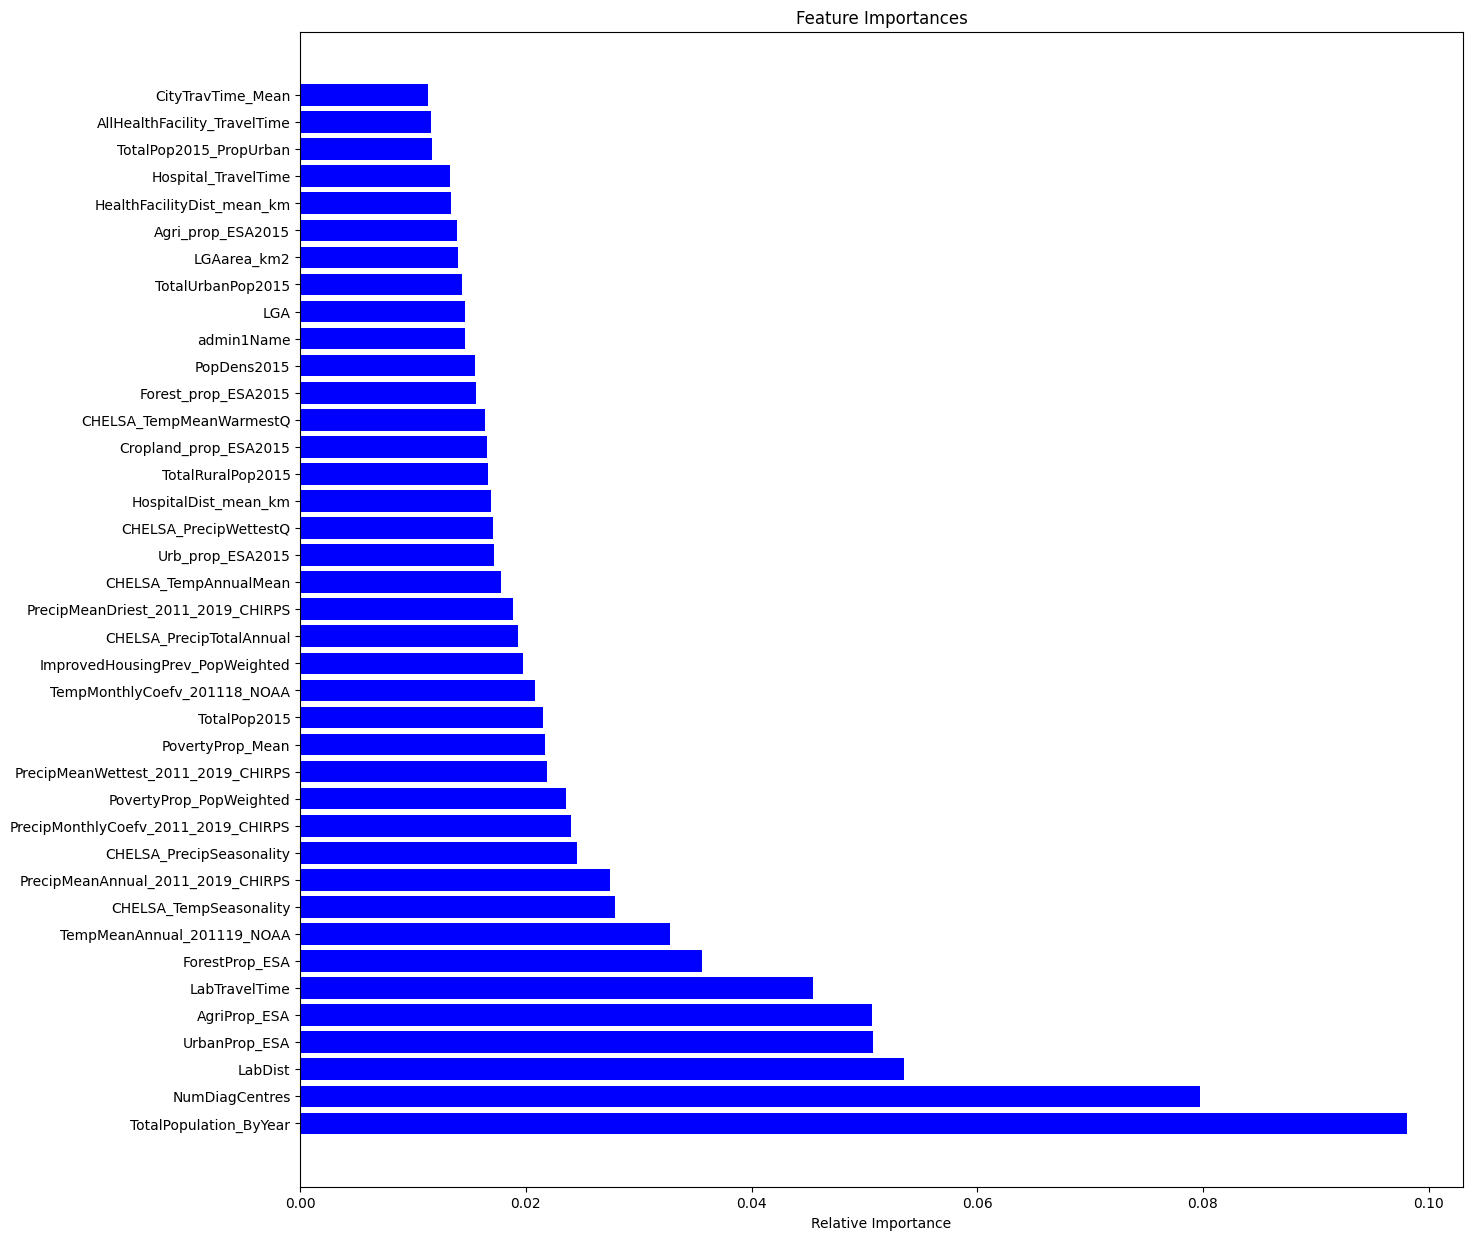

In [15]:
features = x_test.columns
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots(figsize=(15, 15))

ax.set_title("Feature Importances")
ax.barh(range(len(indices)), importances[indices], color='b', align='center')
ax.set_yticks(range(len(indices)), [features[i] for i in indices])
ax.set_xlabel('Relative Importance')
plt.show()

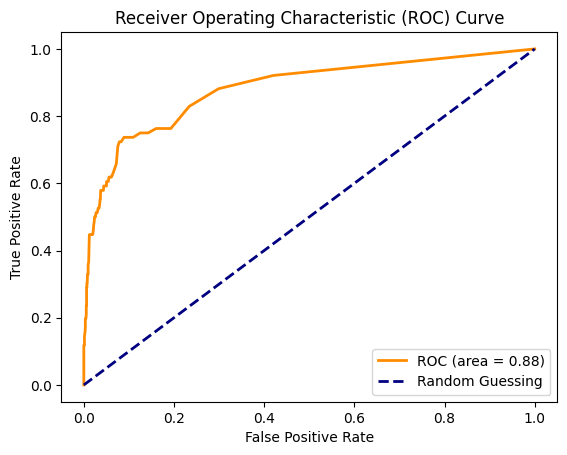

In [16]:
from sklearn.metrics import roc_curve, auc
# Do we need this line?
# yer = clf.predict_proba(x_test)

# AUC / ROC for 2012-2017
y_score = clf.predict_proba(x_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)


plt.plot(fpr, tpr, color='darkorange', lw=2,label='ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [17]:
whatever = clf.s
whatever

<bound method ClassifierMixin.score of RandomForestClassifier(criterion='entropy', random_state=42)>

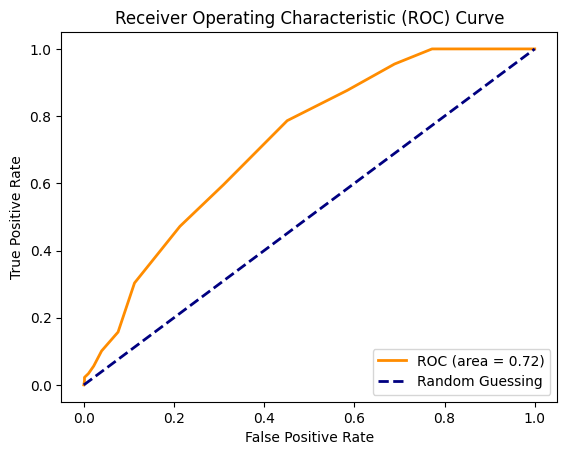

In [18]:
# AUC / ROC for 2018
y18_score = clf.predict_proba(x18)[:, 1]

fpr, tpr, thresholds = roc_curve(y18, y18_score)
roc_auc = auc(fpr, tpr)


plt.plot(fpr, tpr, color='darkorange', lw=2,label='ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

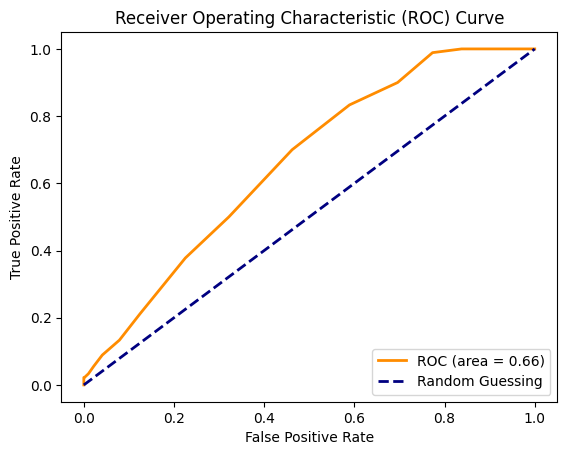

In [19]:
# AUC / ROC for 2019
y19_score = clf.predict_proba(x19)[:, 1]

fpr, tpr, thresholds = roc_curve(y19, y19_score)
roc_auc = auc(fpr, tpr)


plt.plot(fpr, tpr, color='darkorange', lw=2,label='ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

<H2 align="center"> SHAP ANALYSIS </H2>

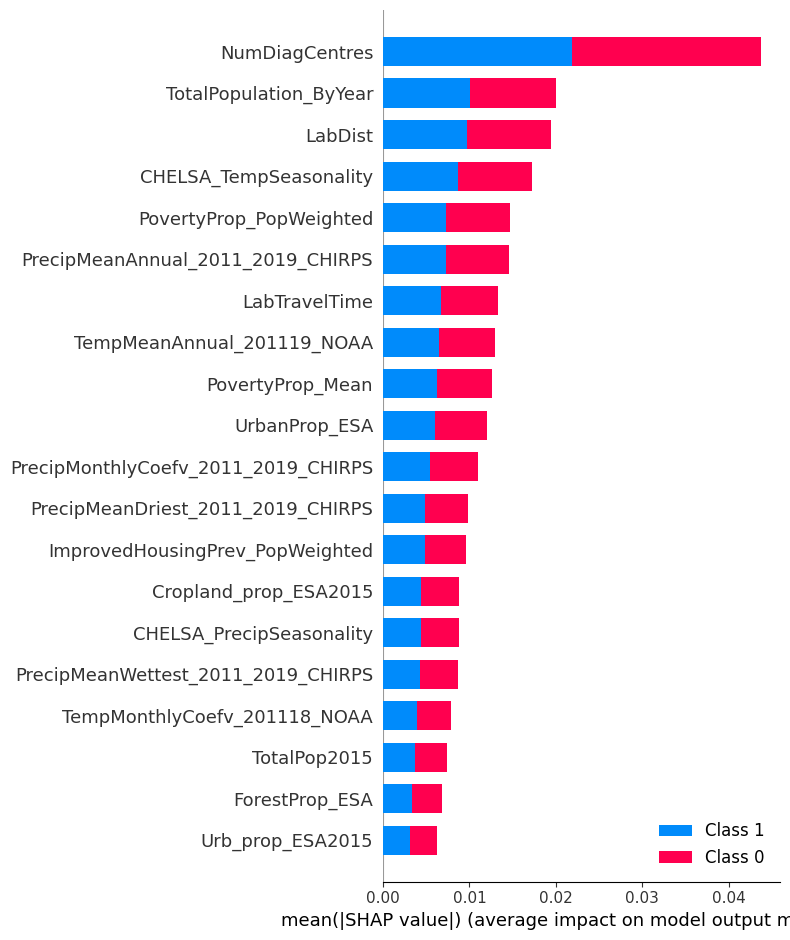

In [20]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test, plot_type='bar')


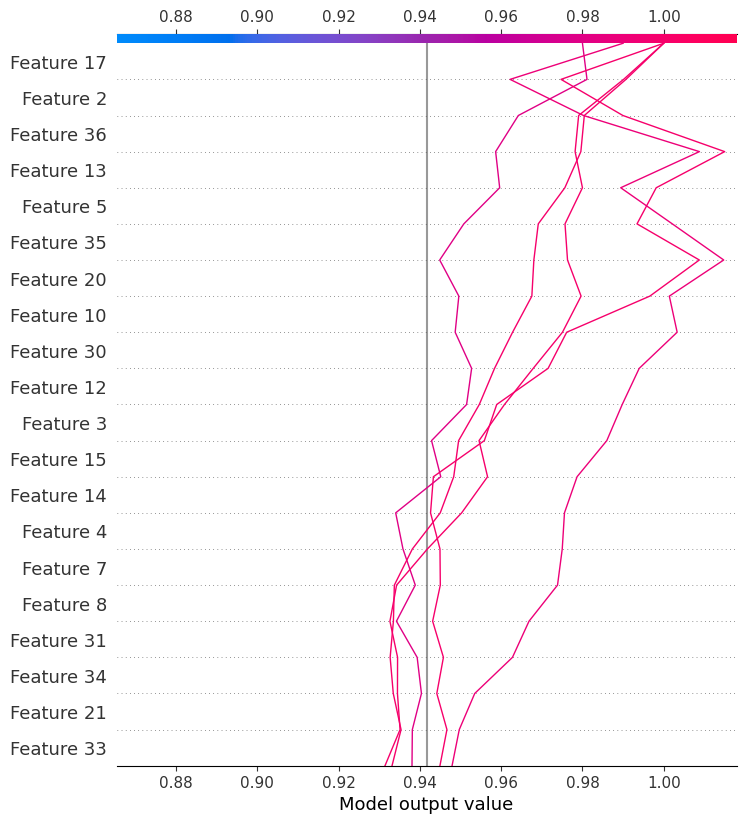

In [21]:
base = explainer.expected_value
base
shap.decision_plot(base_value=base[0], shap_values=shap_values[0][0:5])

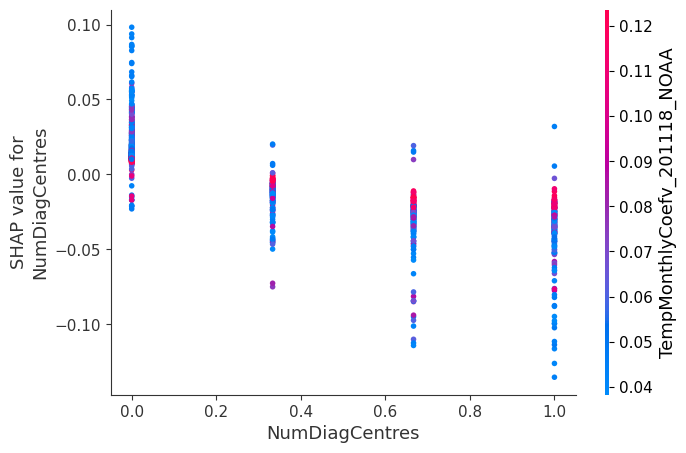

In [22]:
shap.dependence_plot("NumDiagCentres", shap_values[0], x_test)

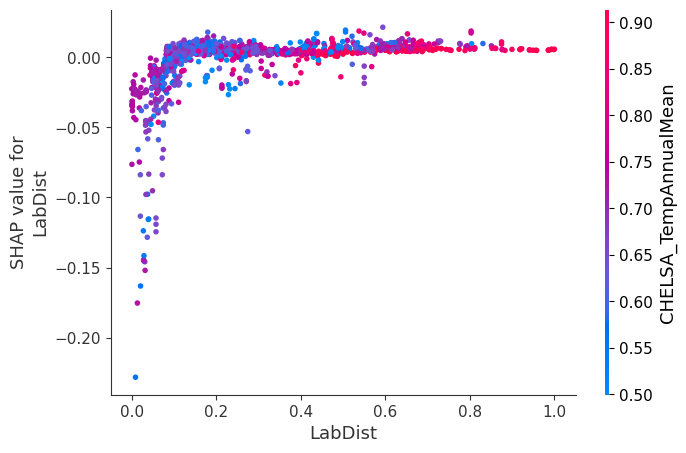

In [23]:
shap.dependence_plot("LabDist", shap_values[0], x_test)

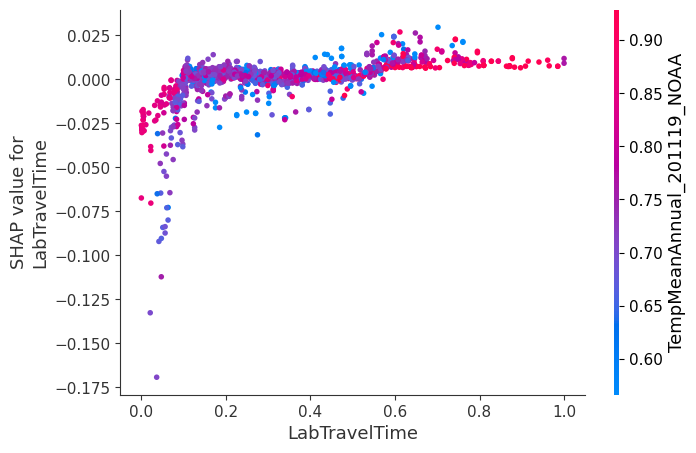

In [24]:
shap.dependence_plot("LabTravelTime", shap_values[0], x_test)

In [25]:
#explainer = shap.Explainer(clf, x_test, check_additivity=False)
explainer = shap.TreeExplainer(clf, x_train, check_additivity=False)
shap_values = explainer(x_train, check_additivity=False)
shap.plots.beeswarm(shap_values[0])

100%|===================| 9285/9288 [01:49<00:00]        

IndexError: tuple index out of range